# Classification of EEG data using Principal Component Analysis

In [6]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os, os.path
import collections
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

Please contact andygb13@gmail.com to get access to the data used in this notebook

In [7]:
win_path = "./Data/Wins"
lose_path = "./Data/Losses"

win_filenames = os.listdir(win_path)
lose_filenames = os.listdir(lose_path)

## Visualizing a data sample before dimensionality reduction

([<matplotlib.axis.XTick at 0x1a88de78cd0>,
 [Text(0, 0, '0'), Text(300, 0, '300'), Text(600, 0, '600')])

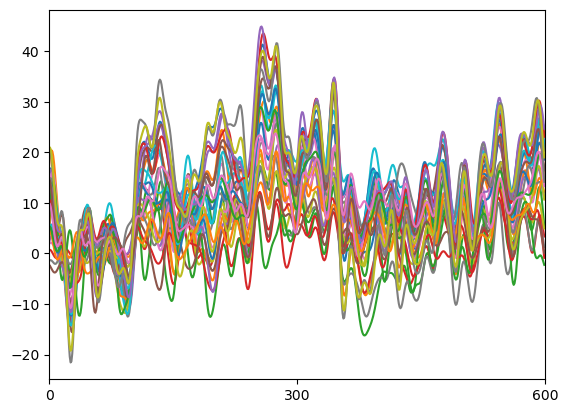

In [8]:
test_data = pd.read_csv(win_path + '\\' + win_filenames[1]) 

fig0 = plt.figure()
plt.plot(np.transpose(test_data))
plt.xlim([0,600])
plt.xticks([0,300,600],[0,300,600])

## Loading and preparing data for dimensionality reduction

In [9]:
X = []
y = []

for filename in win_filenames:
    path = win_path + '\\' + filename
    data = genfromtxt(path, delimiter=',')
    data = np.transpose(data)
    data = data.flatten()
    X.append(data)
    y.append(1)

for filename in lose_filenames:
    path = lose_path + '\\' + filename
    data = genfromtxt(path, delimiter=',')
    data = np.transpose(data)
    data = data.flatten()
    X.append(data)
    y.append(0)

In [10]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

(30441, 18000) (30441,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

## Visualizing label count for training data

([<matplotlib.axis.XTick at 0x1a88139f190>,
 [Text(0, 0, 'Lose'), Text(1, 0, 'Win')])

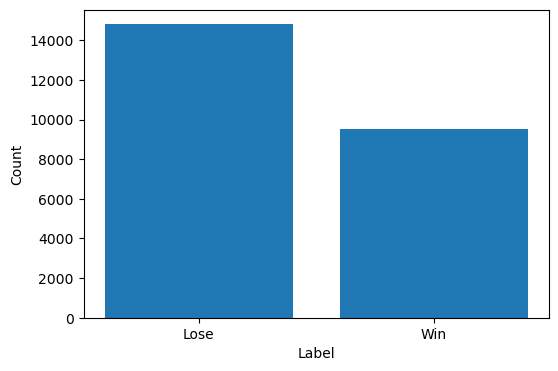

In [12]:
fig3 = plt.figure(figsize=(6, 4))
plt.bar(collections.Counter(y_train).keys(), collections.Counter(y_train).values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1], ['Lose', 'Win'])

## Scaling and reducing dimensionality of the data using PCA

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

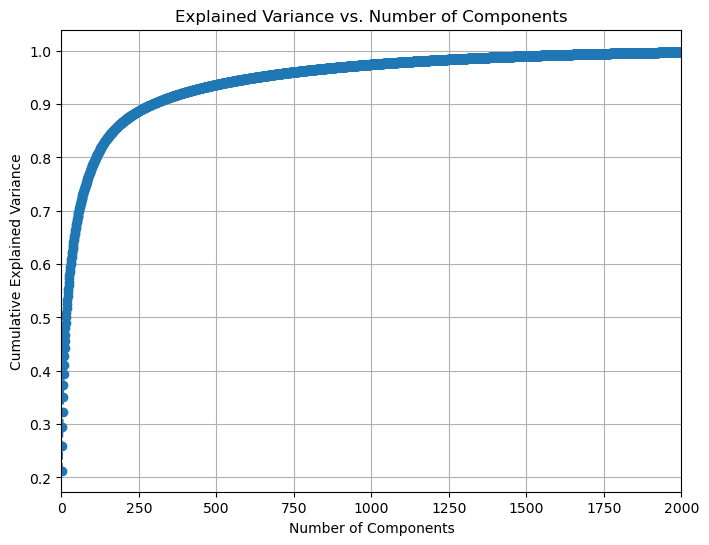

In [15]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.xlim((0,2000))

# Find the "elbow" point (an arbitrary threshold or visual inspection)
# Choose the number of components accordingly
plt.show()

Using plot above, 750 principal components were selected to keep a cumulative explained variance of 0.95

In [14]:
n_components = 750 # Replace with your chosen number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Model testing

### Random Forests and Gradient Boosted Machines

Random Forests and Gradient Boosting Machines could be particularly suitable for EEG data classification due to their ability to handle complex, non-linear relationships inherent in EEG signals. These models excel in managing high-dimensional spaces common in EEG data, robustly avoiding overfitting through ensemble and boosting techniques. They offer a balance between performance and interpretability, providing insights through feature importance scores. Additionally, their adaptability in handling different data types and resilience against imbalanced datasets make them strong candidates for EEG analysis, although success heavily relies on careful parameter tuning and validation tailored to the specific EEG dataset and classification task.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize models
models = {
    'GBM': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
}

# Train models
for name, model in models.items():
    model.fit(X_train_pca, y_train)

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_rep
    }

for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Classification Report:\n{metrics['Classification Report']}\n")


Model: GBM
Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      3649
           1       0.61      0.18      0.28      2440

    accuracy                           0.63      6089
   macro avg       0.62      0.55      0.52      6089
weighted avg       0.62      0.63      0.56      6089


Model: Random Forest
Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.97      0.75      3649
           1       0.59      0.06      0.11      2440

    accuracy                           0.61      6089
   macro avg       0.60      0.52      0.43      6089
weighted avg       0.60      0.61      0.49      6089




The Gradient Boosting Machine (GBM) and Random Forest models show moderate accuracy in EEG data classification, with GBM at 0.63 and Random Forest at 0.61. Both models exhibit a bias towards the majority class, demonstrated by higher recall for class 0 and significantly lower recall for class 1. This suggests a tendency to favor the majority class and a struggle in correctly identifying the minority class. Fine-tuning and balanced class weighting may be necessary to improve the models' performance across both classes.

### Simple CNN

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


def create_1d_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Adjust the input_shape to match your data format, e.g., (750, 1) for 750 features with 1 channel
input_shape = (750, 1)
model = create_1d_cnn_model(input_shape)
model.summary()

# Ensure the data is in the correct shape for a 1D CNN
X_train = X_train_pca.reshape((-1, 750, 1))
X_test = X_test_pca.reshape((-1, 750, 1))

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 748, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 374, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 372, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 186, 128)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 23808)             0         
                                                                 
 dense (Dense)               (None, 64)                1

The simple CNN model, demonstrates a promising learning trend over 10 epochs. Initially, it starts with an accuracy of 60.57% and a loss of 0.6784. As training progresses, there's a consistent improvement in accuracy, reaching 69.95% by the 10th epoch, alongside a decreasing loss trend, ending at 0.5386. However, the validation accuracy shows a less consistent pattern, peaking at 63.21% in the 5th epoch and then fluctuating, settling at 61.78% by the 10th epoch. This discrepancy between training and validation performance suggests a potential overfitting issue, as the model performs better on training data compared to unseen validation data. Regularization methods or further tuning might be needed to enhance the model's generalization capabilities on new data.